In [2]:
import pref_voting
from pref_voting.profiles import Profile

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from string import ascii_lowercase
import matplotlib.patches as patches

from collections import defaultdict

In [4]:
from tabulate import tabulate, SEPARATING_LINE

In [5]:
party_colors = {p: c for p, c in zip(ascii_lowercase, plt.rcParams['axes.prop_cycle'].by_key()['color'])}

In [6]:
### This code was generated with the help of Gemini.

def apply_angled_stripes(ax, bars, colors, angle=45, stripe_width=0.5):
    """
    Applies a repeating angled stripe pattern to existing bars.
    
    Parameters:
    - ax: The matplotlib axes object.
    - bars: The container of bars (returned by ax.bar).
    - colors: List of colors to cycle through (e.g., ['red', 'white', 'blue']).
    - angle: Angle of stripes in degrees (default 45).
    - stripe_width: Width of each stripe relative to the x-axis.
    """
    
    # Convert angle to radians for calculation
    rads = np.deg2rad(angle)
    
    for bar in bars:
        # 1. Get the geometry of the current bar
        bbox = bar.get_bbox()
        x0, y0 = bbox.x0, bbox.y0
        x1, y1 = bbox.x1, bbox.y1
        w = x1 - x0
        h = y1 - y0
        
        # 2. Hide the original bar face color, keep edge
        bar.set_facecolor('none')
        bar.set_edgecolor('black')
        
        # 3. Create a canvas large enough to cover the rotated bar
        # We define a grid of stripes that covers the bounding box
        # We extend the range to ensure coverage after rotation
        diagonal_length = np.sqrt(w**2 + h**2)
        
        # Determine number of stripes needed
        # We generate stripes across a wider area to handle the rotation
        num_stripes = int((w + h) / stripe_width) * 2
        
        # 4. Generate and Rotate Stripes
        for i in range(-num_stripes, num_stripes):
            # Calculate stripe position
            # We create vertical stripes first, then rotate them
            # The x-position determines the sequence
            color = colors[i % len(colors)]
            
            # Define a long rectangle (the stripe)
            # It needs to be tall enough to cover the bar when rotated
            stripe_h = diagonal_length * 2
            stripe_x = x0 + (i * stripe_width)
            
            # Create the patch (initially vertical)
            # We center it vertically on the bar's midpoint
            rect = patches.Rectangle(
                (stripe_x, y0 - stripe_h/2 + h/2), 
                stripe_width, 
                stripe_h, 
                facecolor=color, 
                edgecolor='none',
                angle=0 # We will rotate using transform
            )
            
            # 5. Apply Rotation
            # We rotate around the center of the BAR, not the stripe
            t = (plt.matplotlib.transforms.Affine2D()
                 .rotate_deg_around(x0 + w/2, y0 + h/2, -angle) # Negative for intuitive direction
                 + ax.transData)
            rect.set_transform(t)
            
            # 6. Clip the stripe to the bar's shape
            # This is the magic step: The stripe only shows where it overlaps the bar
            rect.set_clip_path(bar)
            
            # Add to plot
            ax.add_patch(rect)

In [7]:
def average_position(coalition, positions):
    return sum(positions[p] for p in coalition) / len(coalition)

def avg_opt(coalition, positions):
    return average_position(coalition, positions), optimist(coalition, positions)

def avg_pes(coalition, positions):
    return average_position(coalition, positions), pessimist(coalition, positions)

def optimist(coalition, positions):
    return min(positions[p] for p in coalition)

def pessimist(coalition, positions):
    return max(positions[p] for p in coalition)

In [8]:
def form_party_coalitions(prof, coalitions, voter_behavior=optimist, tiebreaker=pessimist):
    if coalitions and not isinstance(coalitions[0], list):
        coalitions = [coalitions]


    # Compute the new integer entries and labels for all parties (and coalitions).
    in_coalitions = {c for coalition in coalitions for c in coalition}
    singleton_coalitions = [[c] for c in range(prof.num_cands) if c not in in_coalitions]
    new_names = dict()
    cmap = dict()
    for i, c in enumerate(c for c in range(prof.num_cands) if c not in in_coalitions):
        new_names[c] = i
        cmap[i] = prof.cmap[c]
    # Continue indexing with i, now for the coalitions
    first_coalition_index = i + 1

    for i, coalition in enumerate(coalitions):
        for c in coalition:
            new_names[c] = first_coalition_index + i
        cmap[first_coalition_index + i] = ''.join(prof.cmap[c] for c in coalition)

    num_cands = first_coalition_index + i + 1

    # Compute the new ranking based off of the scoring given by voter_behavior.
    new_rankings = []
    old_rankings, rcounts = prof.rankings_counts
    for ranking in old_rankings:
        ranking = list(ranking)
        # print('Previous ranking', [prof.cmap[c] for c in ranking])
        new_ranking = [
            new_names[c[0]]
            for _, _, c in sorted(
                (voter_behavior(coal, [ranking.index(i) + 1 for i in range(prof.num_cands)]),
                 tiebreaker(coal, [ranking.index(i) + 1 for i in range(prof.num_cands)]),
                 coal)
                for coal in singleton_coalitions + coalitions)
        ]
        new_rankings.append(new_ranking)
        # print('New ranking', [cmap[c] for c in new_ranking])

    
    # # Assume each voter acts optimistically.
    # new_rankings = []
    # for ranking in prof.ranking_types:
    #     new_ranking = []
    #     coalition_ranked = [False] * num_cands
    #     for c in ranking:
    #         new_name = new_names[c]
    #         if coalition_ranked[new_name]:
    #             continue
    #         coalition_ranked[new_name] = True
    #         new_ranking.append(new_name)
    #     new_rankings.append(new_ranking)

    return Profile(new_rankings, rcounts, cmap).anonymize()
    

In [29]:
### This code was generated with the help of Gemini.

def plot_pref_voting_plurality(profile, title="Candidate Plurality Scores", color='skyblue', positions=None):
    if positions is None:
        positions = list(range(profile.num_cands))
    # 1. Extract Plurality Scores using the library's built-in method
    # returns a dict {candidate_idx: score}
    scores_dict = profile.plurality_scores()
    
    # 2. Extract Candidate Names
    # Profile objects usually store a mapping from index to name in 'cmap'
    # If cmap is empty or default, we just use the candidate indices
    candidates = list(scores_dict.keys())
    scores = list(scores_dict.values())
    
    # Map indices to names if available
    labels = [profile.cmap[c] if hasattr(profile, 'cmap') and (c in profile.cmap or isinstance(profile.cmap, list)) else str(c) 
              for c in candidates]
    
    # 3. Calculate Percentages
    total_votes = sum(scores)
    percentages = [(s / total_votes) * 100 for s in scores]
    
    # 4. Sort Data (Descending Order)
    # Zip everything together, sort by score (descending), then unzip
    # sorted_data = sorted(zip(labels, scores, percentages), key=lambda x: x[1], reverse=True)
    sorted_data = zip(labels, scores, percentages)
    sorted_labels, sorted_scores, sorted_pcts = zip(*sorted_data)
    
    # 5. Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(positions, sorted_scores, color=[party_colors.get(label, color) for label in sorted_labels], edgecolor='black', width=0.1)
    # apply_angled_stripes(ax, bars, ['red', 'green'], angle=45, stripe_width=0.05)

    ax.set_xticks(positions)      # Tell MPL where to put the tick marks
    ax.set_xticklabels(sorted_labels)    # Tell MPL what text to put at those marks
    
    # Formatting
    # ax.set_ylabel('Plurality Score (Votes)')
    # ax.set_title(title)
    ax.set_ylim(0, max(sorted_scores) * 1.15) # Add headroom for labels
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Rotate x-labels if there are many candidates
    # plt.xticks(rotation=0 if len(candidates) < 5 else 45)
    
    # 6. Add Percentage Labels
    for bar, pct in zip(bars, sorted_pcts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.0f}%',
                ha='center', va='bottom', fontsize=plt.rcParams['xtick.labelsize'], fontweight='bold')
                
    plt.tight_layout()
    
    return fig, ax

In [20]:
def generate_profile(party_positions, party_sizes):
    size_total = sum(party_sizes)
    
    rankings = []
    # counts = [int(1000 * size / size_total) for size in party_sizes]
    for party, (pos, size) in enumerate(zip(party_positions, party_sizes)):
        scored = [(abs(pos - other_pos), other) for other, other_pos in enumerate(party_positions)]
        scored.sort()
        # Check for equal distances:
        for i, ((score_x, x), (score_y, y)) in enumerate(zip(scored, scored[1:])):
            if score_x == score_y:
                print('Warning: parties {} and {} are the same distance from {}: {}'.format(x, y, party, score_x))
        
        rankings.append([
            p
            for _, p
            in scored
        ])

    return Profile(rankings, party_sizes, cmap=list(ascii_lowercase[:len(party_positions)]))

In [44]:
behaviors = [optimist, pessimist, avg_opt, avg_pes]
behavior_names = ["OPT", "PES", "AVG + OPT", "AVG + PES"]

def generate_table(profile, coalition_sets):
    rows = []
    for coalitions in coalition_sets:
        pec_scores = defaultdict(list)
        for beh, name in zip(behaviors, behavior_names):
            coalition_profile = form_party_coalitions(profile, coalitions, voter_behavior=beh)
            scores = coalition_profile.plurality_scores()
            for cand in range(coalition_profile.num_cands):
                pec_scores[coalition_profile.cmap[cand]].append(scores[cand] / coalition_profile.num_voters)
        for pec, scores in pec_scores.items():
            rows.append([pec] + ['{}\\%'.format(round(100 * score, 1)) for score in scores])
        rows.append(SEPARATING_LINE)
    # Remove the final separating line, not necessary
    rows.pop(-1)
    print(tabulate(rows, headers=['PEC'] + behavior_names, tablefmt="latex_raw", colalign=["center"] + ["right"] * len(behaviors)))
# print(tabulate(rows, headers=['PEC'] + behavior_names))


In [45]:
# Set global parameters
params = {
    'figure.figsize': (3.4, 2.5),    # Standard width for papers
    'axes.titlesize': 22,        # Title
    'axes.labelsize': 20,        # X and Y labels
    'xtick.labelsize': 18,       # Tick marks
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    'lines.linewidth': 2,        # Thicker lines for visibility
    'font.family': 'serif'       # Matches LaTeX documents
}
plt.rcParams.update(params)

\begin{tabular}{crrrr}
\hline
  PEC  &    OPT &    PES &   AVG + OPT &   AVG + PES \\
\hline
   b   & 16.0\% & 19.0\% &      19.0\% &      19.0\% \\
   c   & 30.0\% & 30.0\% &      30.0\% &      30.0\% \\
   d   & 35.0\% & 35.0\% &      35.0\% &      35.0\% \\
   e   & 14.0\% & 16.0\% &      16.0\% &      16.0\% \\
  af   &  5.0\% &  0.0\% &       0.0\% &       0.0\% \\
\hline
\end{tabular}


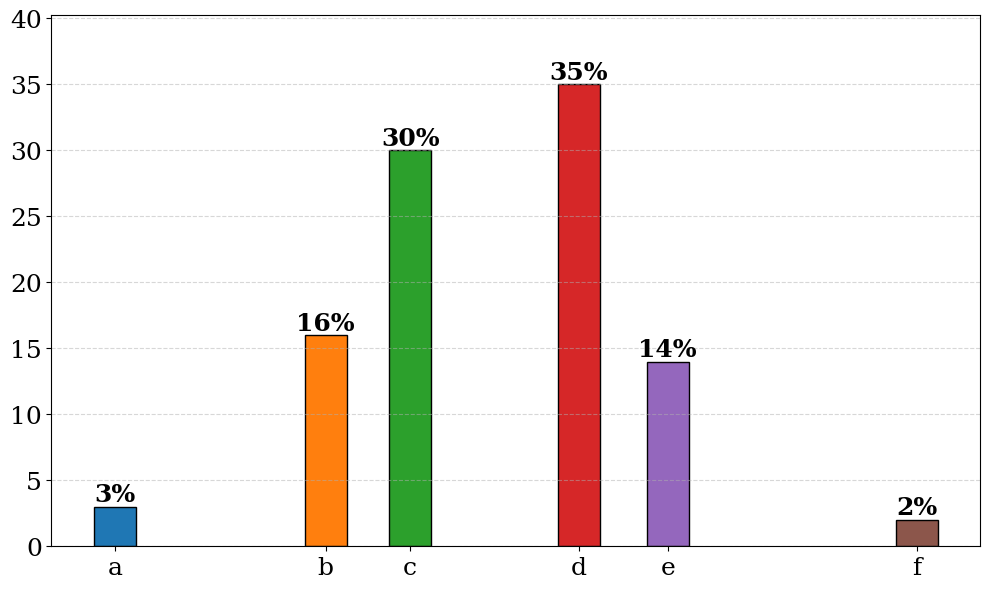

In [46]:
party_positions = [-0.9, -0.4, -0.2, 0.2, 0.41, 1]
party_sizes = [3, 16, 30, 35, 14, 2]

coalition_sets = [[0, 5]]

profile = generate_profile(party_positions, party_sizes)
generate_table(profile, coalition_sets)
fig, _ = plot_pref_voting_plurality(profile, positions=party_positions)
fig.savefig('opposite.pdf', format='pdf', bbox_inches='tight')

\begin{tabular}{crrrr}
\hline
  PEC  &    OPT &    PES &   AVG + OPT &   AVG + PES \\
\hline
   a   &  3.0\% &  3.0\% &       3.0\% &       3.0\% \\
   b   & 22.0\% & 22.0\% &      22.0\% &      22.0\% \\
   d   & 23.0\% & 74.0\% &      23.0\% &      74.0\% \\
   f   &  1.0\% &  1.0\% &       1.0\% &       1.0\% \\
  ce   & 51.0\% &  0.0\% &      51.0\% &       0.0\% \\
  \\
   a   &  3.0\% &  3.0\% &       3.0\% &       3.0\% \\
   b   & 22.0\% & 22.0\% &      22.0\% &      22.0\% \\
   f   &  1.0\% &  1.0\% &       1.0\% &       1.0\% \\
  cde  & 74.0\% & 74.0\% &      74.0\% &      74.0\% \\
\hline
\end{tabular}


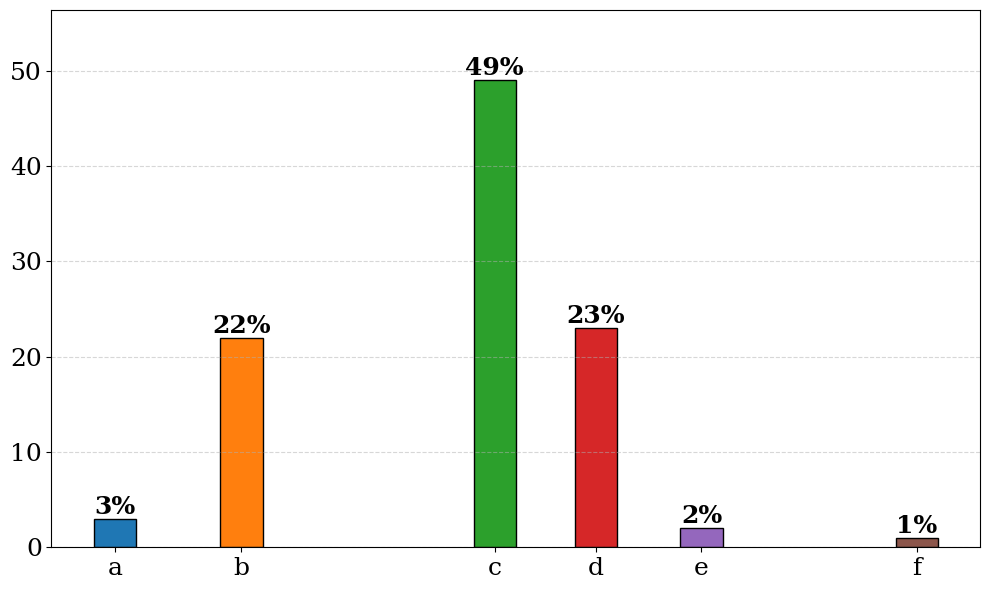

In [33]:
party_positions = [-0.9, -0.6, 0, 0.24, 0.49, 1]
party_sizes = [3, 22, 49, 23, 2, 1]

coalition_sets = [[2, 4],[2, 3, 4]]

profile = generate_profile(party_positions, party_sizes)
generate_table(profile, coalition_sets)
fig, _ = plot_pref_voting_plurality(profile, positions=party_positions)
fig.savefig('majority.pdf', format='pdf', bbox_inches='tight')


\begin{tabular}{crrrr}
\hline
  PEC  &    OPT &    PES &   AVG + OPT &   AVG + PES \\
\hline
   a   &  6.0\% &  6.0\% &       6.0\% &       6.0\% \\
   b   & 20.0\% & 20.0\% &      20.0\% &      20.0\% \\
   d   & 45.0\% & 50.0\% &      50.0\% &      50.0\% \\
   f   & 20.0\% & 20.0\% &      20.0\% &      20.0\% \\
   g   &  4.0\% &  4.0\% &       4.0\% &       4.0\% \\
  ce   &  5.0\% &  0.0\% &       0.0\% &       0.0\% \\
  \\
   a   &  6.0\% &  6.0\% &       6.0\% &       6.0\% \\
   b   & 20.0\% & 23.0\% &      20.0\% &      20.0\% \\
   f   & 20.0\% & 22.0\% &      20.0\% &      20.0\% \\
   g   &  4.0\% &  4.0\% &       4.0\% &       4.0\% \\
  cde  & 50.0\% & 45.0\% &      50.0\% &      50.0\% \\
\hline
\end{tabular}


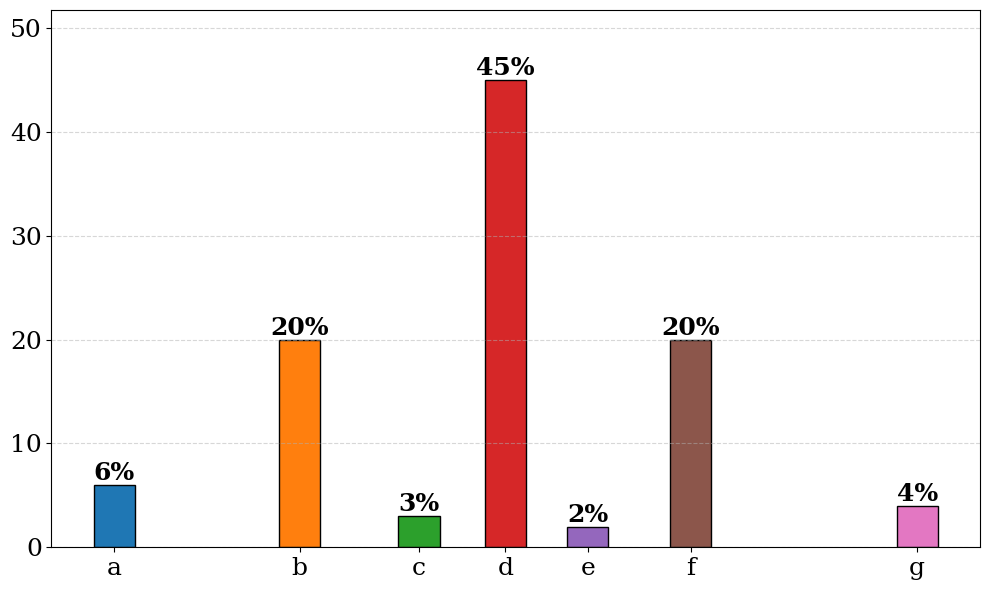

In [34]:
party_positions = [-0.95, -0.5, - 0.21, 0, 0.2, 0.45, 1]
party_sizes = [6, 20, 3, 45, 2, 20, 4]

coalition_sets = [[2, 4],[2, 3, 4]]

profile = generate_profile(party_positions, party_sizes)
generate_table(profile, coalition_sets)
fig, _ = plot_pref_voting_plurality(profile, positions=party_positions)
fig.savefig('centrists.pdf', format='pdf', bbox_inches='tight')